# SentencePiece를 이용한 영화 리뷰 감성 분석

<br>

## 목차

1. [Corpus 데이터 로드](#Corpus-데이터-로드)
2. [SentencePiece 모델 학습](#SentencePiece-모델-학습)
3. [학습 데이터 로드](#학습-데이터-로드)
4. [데이터 전처리](#데이터-전처리)
    - [문장 길이 분포 확인](#문장-길이-분포-확인)
    - [공백 삭제](#공백-삭제)
    - [min_len, max_len 설정](#min_len,-max_len-설정)
5. [토크나이저 생성](#토크나이저-생성)
6. [Train, Validation, Test 데이터셋 분리](#Train,-Validation,-Test-데이터셋-분리)
7. [모델 설계 및 학습](#모델-설계-및-학습)
8. [모델 평가](#모델-평가)

<hr>

In [77]:
import os
import re
import urllib.request
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import keras
from sklearn.model_selection import train_test_split

import sentencepiece as spm

## Corpus 데이터 로드

In [2]:
base_path = os.getenv('HOME') + '/aiffel/aiffel_projects/goingdeeper/GD2_sp_tokenizer'
file_path = base_path + '/data/korean-english-park.train.ko'

with open(file_path, 'r') as f:
    raw = f.read().splitlines()
    
print('Data Size:', len(raw))
print('Example:')
for sen in raw[0:100][::20]:
    print('>>', sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


min_len: 1
max_len: 377
mean_len: 60


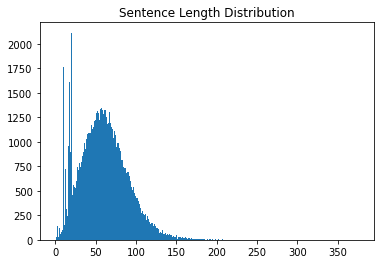

In [3]:
# 문장 길이 분포 시각화
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length:
        min_len = length
    if max_len < length:
        max_len = length
    sum_len += length

print('min_len:', min_len)
print('max_len:', max_len)
print('mean_len:', sum_len//len(raw))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw:
    sentence_length[len(sen)-1] += 1
    
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title('Sentence Length Distribution')
plt.show()

In [4]:
# 길이가 1인 문장 확인
def check_sentence_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return
            
check_sentence_length(raw, 1)

’


In [5]:
# 같은 길이의 문장 개수가 1500개 초과인 문장들 확인
for idx,_sum in enumerate(sentence_length):
    if _sum > 1500:
        print('Outlier Index:', idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


In [6]:
check_sentence_length(raw, 11) # 중복 문장 많음

라고 조던이 말했다.
- 모르고 있습니다.
- 네, 보이는군요.
디즈니사만이 아니다.
큰 파티는 아니지요.
의자는 비어 있었다.
이 일은 계속됩니다.
나는 크게 실망했다.
그 이유는 간단하다.
이력서와 자기 소개서
시대가 변하고 있다.
는 돌발질문을 했다.
9. 몇 분간의 명상
하와이, 빅 아일랜드
키스를 잘 하는 방법
키스를 잘 하는 방법
스피어스가 뚱뚱한가?
산 위를 나는 느낌.
세 시간쯤 걸었을까?
(아직 읽고있습니까?
처음에는 장난이었다.
우리는 운이 좋았다.
아기가 숨을 멈출 때
건물 전체 무너져내려
그녀의 아름다운 눈.
대답은 다음과 같다.
"사과할 것이 없다.
폭탄테러가 공포 유발
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1

Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


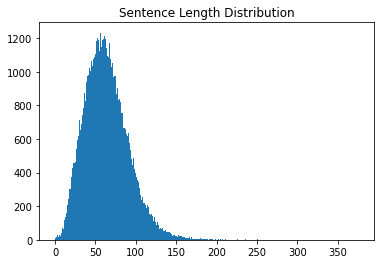

In [7]:
# 중복 처리를 위해 set 이용
cleaned_corpus = list(set(raw))
print('Data Size:', len(cleaned_corpus))

# 다시 문장 길이 분포 확인
min_len = 999
max_len = 0
sum_len = 0

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length:
        min_len = length
    if max_len < length:
        max_len = length
    sum_len += length
    
print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:
    sentence_length[len(sen)-1] += 1
    
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title('Sentence Length Distribution')
plt.show()

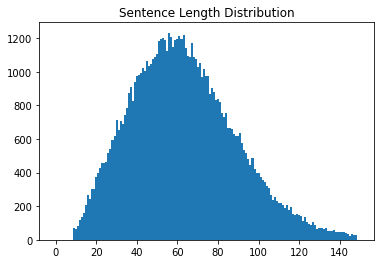

In [8]:
max_len = 150
min_len = 10

filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 다시 길이 분포를 시각화해서 살펴보기
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

## SentencePiece 모델 학습

In [9]:
temp_file = base_path + '/data/korean-english-park.train.ko.temp'

with open(temp_file, 'w') as f:
    for row in filtered_corpus:
        f.write(str(row) + '\n')
        
VOCAB_SIZE = 8000

# --model_type의 default='unigram'
# --model_type='bpe'로 변경 가능
# old interface for train
spm.SentencePieceTrainer.Train('--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file,VOCAB_SIZE))

In [10]:
!ls -l korean_spm*

-rw-r--r-- 1 root root 376924 Sep 28 12:48 korean_spm.model
-rw-r--r-- 1 root root 146388 Sep 28 12:48 korean_spm.vocab


In [11]:
s = spm.SentencePieceProcessor()
s.Load(base_path + '/model/korean_spm.model')

True

## 학습 데이터 로드

- [네이버 영화 댓글 데이터셋](https://github.com/e9t/nsmc)

- 200K reviews in total
    - train.txt: 150K reviews
    - test.txt: 50K reviews
- label
    - each class is sampled equally
    - 0: negative \(100K reviews of ratings 1-4\)
    - 1: positive \(100K reviews of ratings 9-10\)
    - neutral reviews\(ratings 5-8\) are excluded
    
- All reveiws are shorter than 140 characters

In [12]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7fefdb3d1ad0>)

In [13]:
!mv ratings_train.txt ~/aiffel/aiffel_projects/goingdeeper/GD2_sp_tokenizer/data
!mv ratings_test.txt ~/aiffel/aiffel_projects/goingdeeper/GD2_sp_tokenizer/data

In [14]:
train_data = pd.read_table(base_path + '/data/ratings_train.txt')
test_data = pd.read_table(base_path + '/data/ratings_test.txt')

In [15]:
print('train data:', len(train_data))
print('test data:', len(test_data))

train data: 150000
test data: 50000


In [16]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [17]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## 데이터 전처리

- 중복 제거
- 결측치 제거
- 데이터 분포 확인
- 특수문자 제거

In [18]:
# 결측치 확인
train_data.isna().sum()

id          0
document    5
label       0
dtype: int64

In [19]:
test_data.isna().sum()

id          0
document    3
label       0
dtype: int64

In [20]:
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

print('train data:', len(train_data))
print('test data:', len(test_data))

train data: 149995
test data: 49997


<AxesSubplot:>

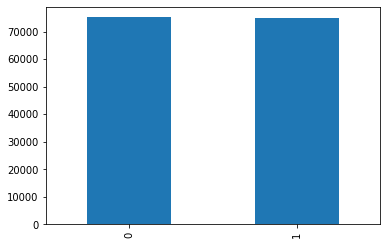

In [21]:
# label 분포 확인
train_data['label'].value_counts().plot(kind='bar')

In [22]:
train_data.groupby('label').size()

label
0    75170
1    74825
dtype: int64

In [23]:
# 특수문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9]"," ")

train_data.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [24]:
# 특수문자 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9]"," ")

test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데 왜 3D로 나와서 제 심기를 불편하게 하죠,0


In [25]:
# 중복 drop
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

print('train data:', len(train_data))
print('test data:', len(test_data))

train data: 145805
test data: 49069


In [26]:
# 결측치 확인
train_data.isna().sum()

id          0
document    0
label       0
dtype: int64

In [27]:
test_data.isna().sum()

id          0
document    0
label       0
dtype: int64

### - 문장 길이 분포 확인

In [28]:
train_data['document'][:10]

0                                  아 더빙   진짜 짜증나네요 목소리
1                    흠   포스터보고 초딩영화줄    오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                        교도소 이야기구먼   솔직히 재미는 없다  평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...
5        막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화 ㅋㅋㅋ   별반개도 아까움 
6                                원작의 긴장감을 제대로 살려내지못했다 
7    별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지  정말 발로해도 그것보단...
8                               액션이 없는데도 재미 있는 몇안되는 영화
9        왜케 평점이 낮은건데  꽤 볼만한데   헐리우드식 화려함에만 너무 길들여져 있나 
Name: document, dtype: object

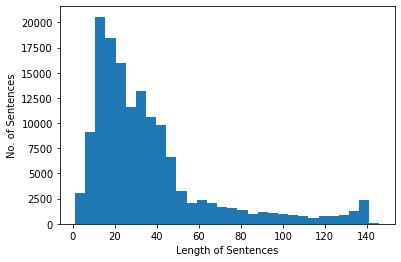

문장의 최장 길이: 146
문장의 평균 길이: 36
문장의 최소 길이: 1


In [29]:
len_train = [len(s) for s in train_data['document']]

plt.hist(len_train, bins=30)
plt.xlabel('Length of Sentences')
plt.ylabel('No. of Sentences')
plt.show()

print('문장의 최장 길이:', max(len_train))
print('문장의 평균 길이:', sum(len_train)//len(len_train))
print('문장의 최소 길이:', min(len_train))

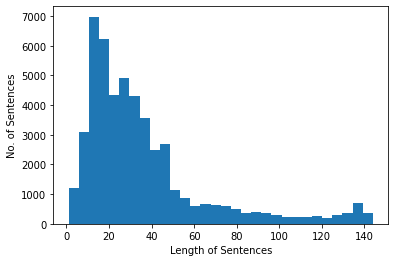

문장의 최장 길이: 144
문장의 평균 길이: 35
문장의 최소 길이: 1


In [30]:
len_test = [len(s) for s in test_data['document']]

plt.hist(len_test, bins=30)
plt.xlabel('Length of Sentences')
plt.ylabel('No. of Sentences')
plt.show()

print('문장의 최장 길이:', max(len_test))
print('문장의 평균 길이:', sum(len_test)//len(len_test))
print('문장의 최소 길이:', min(len_test))

In [31]:
# 길이가 1인 문장 확인
def check_sentence_length(sentence, length):
    count = 0
    
    for sen in sentence:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

In [32]:
check_sentence_length(train_data['document'], 1)

아
잼
1
4
굿
짱
휴
 
음
ㅎ
ㅋ
즐
굳
네
ㅇ
k
ㅠ
쒯
토
O
똥
z
헐
삼
꽝
풉
ㅅ
왜
ㄴ
쉣
봐
뿌
ㅜ
ㅁ
0
ㅉ
d
흥
찜
귯
린
시
ㅗ
a
c
흠
웅
ㅣ
오
9
쩜
애
헝
쨩
f
움
ㄳ
업
헉
군
b
g
올
걍
허
쀍
로
ㄹ
ㅂ
갑
즛
킥
함
진
ㅡ
잠
곧
ㅍ
h
캬
ㅆ
풋
ㄱ
파
ㄷ
웩
꺅
욜
ㅄ
2
핡


In [33]:
check_sentence_length(train_data['document'], 2)

최고
졸작
대박
버려
망함
굳굳
안습
망작
ㅇㅇ
쵝오
굿 
별루
씐나
쓰렉
볼만
허접
비추
좋다
ㅎㅎ
아나
ㅉㅉ
야 
역시
  
오오
평이
지루
오욈
ㅋㅋ
지송
별로
눈물
당연
쩔어
별노
몰입
졸잼
돋네
오글
이응
첨봄
최악
잼씀
ok
유후
감동
gg
조앙
1점
표절
명작
으휴
에효
ㄱ굿
굿잡
잼나
10
ㅜㅜ
우왕
거지
굿굿
좋음
실망
애이
짱임
전설
mm
와우
등록
하위
그닥
뭉클
삼류
HN
윤하
섹시
실화
머냐
수작
꿀잼
동감
dd
굳ㅋ
굳 
추천
좋아
55
안봐
개쩜
올레
난해
ㅠㅠ
뭐니
ㅁㅁ
뭥미
쓰랙
좇 
오우
미안
걸작
안봄


In [34]:
check_sentence_length(train_data['document'], 146)

 스폰으로 먹고사는 방송이라 어쩔수 없다고 하지만  이건 그냥 비현실적인 자동차만    독일3사 슈퍼카 홍보 프로그램도 아니구 대중적인 자동차 방송으로 이루어 졌으면 합니다  보는내내   카탈로그 책자  를   동영상으로 보여주는 방송   같아서 씁쓸하네요   
   니 짓은 생각않고  웬 복수   의 교훈이라  그럼   서바이벌 액션  으로 홍보하면 안되지  초반 45분은 멋지게 열더니   억지 반전  하드고어로 시간끌다가  허둥지둥 화해로 끝내버리네  90분 러닝타임에 엔딩자막만 11분 틀어주는 해괴망측한 영화   
 2007 02 25  벌교의 한 국밥집  점심    갸는 첫째고  저 놈은 우리 둘째    재문    아줌마  미안해  그냥   아줌마  나 그 남방 잘 어울려ㅠ ㅠ    대식에게 복수하려던 1주일 전  대식의 엄마를 먼저 만났다  사랑의 꽃남방도     o 


### - 공백 삭제

- 공백이 하나 이상일 경우 하나로 대체

In [35]:
def strip_spaces(sentence, df):
    stripped = []
    for sen in sentence:
        sen = sen.split()
        sen = [s for s in sen if s != ' ']
        sen = " ".join(sen)
        stripped.append(sen)
    df['stripped'] = stripped
    return

In [36]:
strip_spaces(train_data['document'], train_data)

train_data.head()

,id,document,label,stripped
0,9976970,아 더빙 진짜 짜증나네요 목소리,0,아 더빙 진짜 짜증나네요 목소리
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나
2,10265843,너무재밓었다그래서보는것을추천한다,0,너무재밓었다그래서보는것을추천한다
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0,교도소 이야기구먼 솔직히 재미는 없다 평점 조정
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...


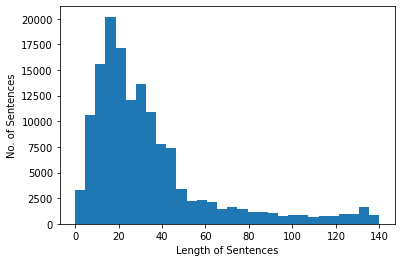

문장의 최장 길이: 140
문장의 평균 길이: 33
문장의 최소 길이: 0


In [37]:
len_train = [len(s) for s in train_data['stripped']]

plt.hist(len_train, bins=30)
plt.xlabel('Length of Sentences')
plt.ylabel('No. of Sentences')
plt.show()

print('문장의 최장 길이:', max(len_train))
print('문장의 평균 길이:', sum(len_train)//len(len_train))
print('문장의 최소 길이:', min(len_train))

In [38]:
check_sentence_length(train_data['stripped'], 1)

아
잼
즐
끙
1
4
와
굿
굿
짱
휴
야
음
ㅎ
ㅋ
즐
굳
하
네
굿
ㅇ
굿
k
ㅠ
굿
음
짱
우
쒯
아
쩝
토
아
즐
굿
O
똥
흠
z
헐
쩝
삼
꽝
음
음
굳
굿
아
풉
ㅅ
아
왜
ㄴ
쉣
좇
봐
뿌
ㅜ
참
ㅁ
0
ㅉ
d
흥
음
찜
흠
귯
린
아
후
쨩
흠
시
굿
짱
ㅗ
왜
a
c
흠
음
웅
헐
ㅣ
굿
휴
굿
오
짱
짱
풉
오
b
9
흥
굿
쩜
우
허
헐


In [39]:
strip_spaces(test_data['document'], test_data)

test_data.head()

,id,document,label,stripped
0,6270596,굳 ㅋ,1,굳 ㅋ
1,9274899,GDNTOPCLASSINTHECLUB,0,GDNTOPCLASSINTHECLUB
2,8544678,뭐야 이 평점들은 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0,뭐야 이 평점들은 나쁘진 않지만 10점 짜리는 더더욱 아니잖아
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0,지루하지는 않은데 완전 막장임 돈주고 보기에는
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데 왜 3D로 나와서 제 심기를 불편하게 하죠,0,3D만 아니었어도 별 다섯 개 줬을텐데 왜 3D로 나와서 제 심기를 불편하게 하죠


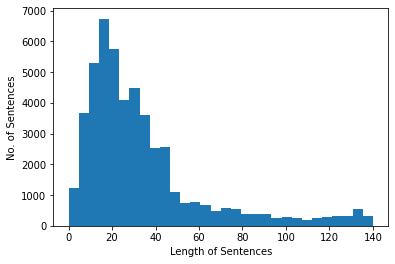

문장의 최장 길이: 140
문장의 평균 길이: 33
문장의 최소 길이: 0


In [40]:
len_test = [len(s) for s in test_data['stripped']]

plt.hist(len_test, bins=30)
plt.xlabel('Length of Sentences')
plt.ylabel('No. of Sentences')
plt.show()

print('문장의 최장 길이:', max(len_test))
print('문장의 평균 길이:', sum(len_test)//len(len_test))
print('문장의 최소 길이:', min(len_test))

In [41]:
print('train_data:', train_data.shape)
print('test_data:', test_data.shape)

train_data: (145805, 4)
test_data: (49069, 4)


### - min_len, max_len 설정

In [42]:
cnt = 0

for l in len_train:
    if 2 <= l <= 60:
        cnt += 1
        
print(f'문장 길이가 2 이상 60 이하인 train_data 비율: {cnt/train_data.shape[0]*100:.2f}%')

문장 길이가 2 이상 60 이하인 train_data 비율: 86.70%


In [43]:
MIN_LEN = 2
MAX_LEN = 60

In [44]:
# 해당하는 문장 길이만 남기기
train_data = train_data[(train_data['stripped'].map(len) <= MAX_LEN)&(train_data['stripped'].map(len) >= MIN_LEN)]

train_data.shape

(126408, 4)

In [45]:
test_data = test_data[(test_data['stripped'].map(len) <= MAX_LEN)&(test_data['stripped'].map(len) >= MIN_LEN)]

test_data.shape

(42475, 4)

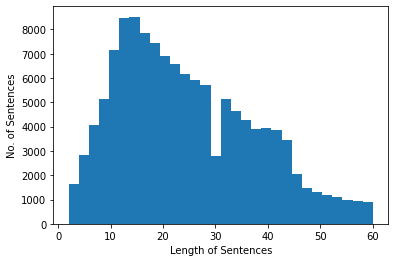

문장의 최장 길이: 60
문장의 평균 길이: 24
문장의 최소 길이: 2


In [48]:
len_train = [len(s) for s in train_data['stripped']]

plt.hist(len_train, bins=30)
plt.xlabel('Length of Sentences')
plt.ylabel('No. of Sentences')
plt.show()

print('문장의 최장 길이:', max(len_train))
print('문장의 평균 길이:', sum(len_train)//len(len_train))
print('문장의 최소 길이:', min(len_train))

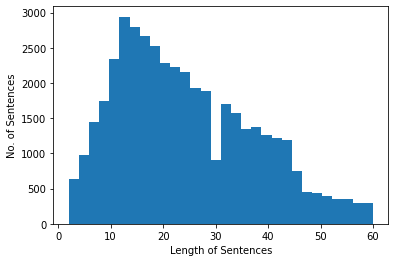

문장의 최장 길이: 60
문장의 평균 길이: 24
문장의 최소 길이: 2


In [49]:
len_test = [len(s) for s in test_data['stripped']]

plt.hist(len_test, bins=30)
plt.xlabel('Length of Sentences')
plt.ylabel('No. of Sentences')
plt.show()

print('문장의 최장 길이:', max(len_test))
print('문장의 평균 길이:', sum(len_test)//len(len_test))
print('문장의 최소 길이:', min(len_test))

## 토크나이저 생성

In [50]:
def sp_tokenize(s, corpus, max_len=MAX_LEN):
    tensor = []
    
    for c in corpus:
        tensor.append(s.EncodeAsIds(c))
        
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=max_len, padding='post')
    
    with open("./model/korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}
    
    for idx, line in enumerate(vocab):
        word = line.split('\t')[0]
        
        word_index.update({idx:word})
        index_word.update({word:idx})

    return tensor, word_index, index_word

In [51]:
train_tensor, word_index, index_word = sp_tokenize(s, train_data['stripped'])
test_tensor, _, _ = sp_tokenize(s, test_data['stripped'])

In [52]:
print(train_tensor.shape)
print(test_tensor.shape)

(126408, 60)
(42475, 60)


## Train, Validation, Test 데이터셋 분리

In [53]:
x_val = train_tensor[:25000]
x_train = train_tensor[25000:]

print('x_train:', x_train.shape)
print('x_val:', x_val.shape)

x_train: (101408, 60)
x_val: (25000, 60)


In [54]:
x_test = test_tensor

print('x_test:', x_test.shape)

x_test: (42475, 60)


In [55]:
y_val = train_data['label'][:25000]
y_train = train_data['label'][25000:]
y_test = test_data['label']

print('y_train:', y_train.shape)
print('y_val:', y_val.shape)
print('y_test:', y_test.shape)

y_train: (101408,)
y_val: (25000,)
y_test: (42475,)


## 모델 설계 및 학습

In [80]:
WORD_VECTOR_DIM = 200  # 워드 벡터의 차원 수

model = Sequential()

model.add(Embedding(VOCAB_SIZE, WORD_VECTOR_DIM))
model.add(LSTM(128))
# model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         1600000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,768,577
Trainable params: 1,768,577
Non-trainable params: 0
_________________________________________________________________


In [81]:
# callbacks
checkpoint_path = base_path + '/model/wv200_min2_max60_model.h5'

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [82]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=50,
                    callbacks=[es, mc],
                    batch_size=60,
                    verbose=1)

Epoch 1/50
1691/1691 [==============================] - 36s 20ms/step - loss: 0.6565 - accuracy: 0.5778 - val_loss: 0.5480 - val_accuracy: 0.7581

Epoch 00001: val_accuracy improved from -inf to 0.75812, saving model to /aiffel/aiffel/aiffel_projects/goingdeeper/GD2_sp_tokenizer/model/wv200_min2_max60_model.h5
Epoch 2/50
1691/1691 [==============================] - 30s 18ms/step - loss: 0.4995 - accuracy: 0.7697 - val_loss: 0.3979 - val_accuracy: 0.8272

Epoch 00002: val_accuracy improved from 0.75812 to 0.82716, saving model to /aiffel/aiffel/aiffel_projects/goingdeeper/GD2_sp_tokenizer/model/wv200_min2_max60_model.h5
Epoch 3/50
1691/1691 [==============================] - 30s 18ms/step - loss: 0.3542 - accuracy: 0.8499 - val_loss: 0.3494 - val_accuracy: 0.8432

Epoch 00003: val_accuracy improved from 0.82716 to 0.84324, saving model to /aiffel/aiffel/aiffel_projects/goingdeeper/GD2_sp_tokenizer/model/wv200_min2_max60_model.h5
Epoch 4/50
1691/1691 [==============================] - 30

## 모델 평가

In [84]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

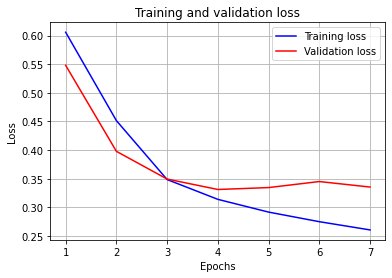

In [85]:
# "ro"는 "빨간색 점"입니다
plt.plot(epochs, loss, 'b', label='Training loss')
# r는 "빨간 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.show()

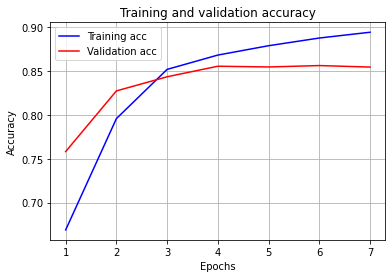

In [86]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.show()

In [87]:
# 테스트셋을 통한 모델 평가
# word_vector_dim=200
results = model.evaluate(x_test, y_test, verbose=1)

1328/1328 [==============================] - 8s 6ms/step - loss: 0.3434 - accuracy: 0.8522


In [89]:
# 지난 모델 로드
prev_model = keras.models.load_model(base_path + '/model/wv100_min2_max60_model.h5')
prev_results = prev_model.evaluate(x_test, y_test, verbose=1)

1328/1328 [==============================] - 8s 5ms/step - loss: 0.3462 - accuracy: 0.8551


In [79]:
# 지난 모델 로드
prev_model = keras.models.load_model(base_path + '/model/wv16_min2_max60_model.h5')
prev_results = prev_model.evaluate(x_test, y_test, verbose=1)

1328/1328 [==============================] - 7s 5ms/step - loss: 0.3428 - accuracy: 0.8535


In [83]:
# 지난 모델 로드
prev_model = keras.models.load_model(base_path + '/model/wv200_min2_max80_model.h5')
prev_results = prev_model.evaluate(x_test, y_test, verbose=1)

1328/1328 [==============================] - 7s 5ms/step - loss: 0.6931 - accuracy: 0.5055


In [96]:
# 실제 리뷰를 분류하는 함수
def sentiment_predict(sentence):
    tensor = []
    
    # tokenize
    tensor.append(s.EncodeAsIds(sentence))
    
    # padding
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    # prediction
    score = float(model.predict(tensor))
    
    if score > 0.5:
        print(f"{score * 100:.2f}% 확률로 positive")
    else:
        print(f"{(1 - score)*100:.2f}% 확률로 negative")

In [97]:
sentiment_predict('2시간 내내 몰입할 수 있었던 영화')

68.07% 확률로 positive


In [98]:
sentiment_predict('감독이 전하고 싶었던 말이 뭔지 모르겠다')

59.75% 확률로 negative


In [99]:
sentiment_predict('그럭저럭')

50.56% 확률로 positive


In [100]:
sentiment_predict('기대를 너무 많이 했나보다')

71.09% 확률로 negative


In [101]:
sentiment_predict('최악')

63.64% 확률로 negative


## 결론 및 회고

#### - 다른 토크나이저와 비교

- 지난 Exploration에서 **Okt 토크나이저**를 이용해 진행했던 결과와 비교하면 모델의 accuracy와 실제 review의 감성 분석 성능 자체에서도 더 뛰어난 결과를 얻지는 못했다.
    - 띄어쓰기 오류나 오타를 바로 잡고, normalize하는 기능이 Okt의 토크나이저가 더 뛰어나기 때문일 것으로 추측한다.
    - 또 sentencepiece 모델학습에 이용한 corpus 데이터가 영화 review와 여러 측면에서 달랐던 것도 그 이유 중 하나로 추측한다.
- SentencePiece 모델에서 bpe보다는 default인 unigram이 약간 더 좋은 정확도를 보였다.


#### - 전처리 및 하이퍼파라미터 조정

- 정확도 향상에 가장 큰 영향을 미친 것은 최대 문장 길이 max_len이었다.
    - max_len을 설정하지 않고 길이 140을 그대로 적용했을 때 val_accuracy는 약 0.5 수준이었다.
    - 이후 min_len은 2, max_len은 80으로 설정해 학습했을 때에도 정확도가 그다지 개선되지 않았다.
    - 그런데 max_len을 60으로 설정하자 갑자기 정확도가 0.85 이상으로 높게 나타났다.
    - 아무래도 최대 문장 길이가 길수록 대부분의 데이터가 0으로 padding되면서 sparse해지는 문제가 있어서 학습이 잘 이루어지지 않았던 것 같다.
- 다른 하이퍼파라미터 조정은 정확도에 소수점 둘째자리 이하의 수 정도로 아주 약간만 영향을 주었다.
    - 그나마 영향을 많이 준 것은 word_vector_dim이었다.

#### - 기타

- 이번 노드에서는 지난 모델들을 저장했다가 다시 load해서 성능이 어떻게 다른지 직접 비교해봤는데 매우 편리했다.